In [9]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng

import simpy

# Using discrete event simulation to help plan a vaccine clinic

Discrete event simulation (DES) is a well established technique for building simulation models of systems characterized by:

* events that happen at discrete points in time (e.g. the arrival of a patient to the vaccine clinic, the completion of the vaccine injection),
* uncertainty in the timing and duration of events (patient show up somewhat randomly even if they have a scheduled appointment, the time to register might depend on various patient characteristics),
* entities (e.g. patients) that flow through a system, 
* contention for resources (patients will wait to at various stages of their vaccine visit to wait for resources such as administrative and clinical staff to become available)
* interest in how the system is performing in terms of things like entity delays, resource utilization, or frequency of certain events.

Typical applications include building models of healtchare delivery systems, manufacturing systems, computer networks, call centers and other service systems, and many others. In all of these systems there are entities that flow (patients, widgets, packets, phone calls) and contend for resources for processing (nurses to give vaccines, machines to process, servers to accept packets, agents to answer the phone). By building a representative simulation model, we can study how such systems might perform if we changes some important entity or resource related inputs: patient arrival rate, machine processing rate, number of servers or number of agents answering calls). The applications are endless and it can be a whole lot cheaper to experiment with a computer model than to experiment with the real system.

DES models are "what if?" models that can help in predicting outputs of a system for a given set of input values. They can help statistically characterize the projected performance of the system being modeled. For example, we might simulate different assembly line configurations to get a sense of the throughput differences for different processes. Or, for a call center they could help predict the impact on customer wait time of a 25% increase in call volume. 

Back in the pcda class, we built a simple simulation model of the Monte-Hall 3-Door problem. FINISH ME

OVERVIEW OF VACCINE SYSTEM TO MODEL

Arrival --> Temperature check --> Registration --> Vaccination --> Schedule follow up --> Wait 15 minutes --> Exit

## Under the hood with DES software

Internally, DES software relies on the notion of a simulation clock and a next event list (the *discrete events*) to decide which event to process next and when to process it. Between these discrete events, nothing happens to the state of the system.

See https://simpy.readthedocs.io/en/latest/topical_guides/simpy_basics.html#how-simpy-works for the details on how SimPy workds

https://realpython.com/simpy-simulating-with-python/

## Getting started with SimPy

From the SimPy in 10 Minutes tutorial:

> SimPy is a discrete-event simulation library. The behavior of active components (like vehicles, customers or messages) is modeled with processes. All processes live in an environment. They interact with the environment and with each other via events.

SimPy makes it easier to build DES models with Python by taking care of things like the simulation clock and the next event list. It provides high level constructs for modeling components of your model as entities, processes and resources.

We are going to build a basic model of a vaccine clinic. It's a prototypical example in that our model must be able to handle:

* a random arrival process
* a multi-stage process in which we have to contend for limited resources at each stage,
* there is uncertainty in some of the processing times,
* we are interested in things like the relationship between patient volume, resource utilization and patient waiting. 

We want to build a model that will be helpful in deciding how many vaccination stations to have, the hours of operation of the vaccine clinic, and the size of the post-vaccine waiting room needed. 

Like the SimPy in 10 Minutes tutorial, I will start with the very basics and keep adding on functionality and complexity. Along the way, I'll try to give you a bit of sense of how SimPy works. Start by reading the [Basic Concepts section of the SimPyin 10 tutorial](https://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html#basic-concepts) to start to become familiar with some fundamental SimPy concepts:

* we model many components of our simulation with *processes*,
* all of our processes live in a SimPy *environment*,
* the processes interact with each other and the SimPy environent through *events*.

## Generators

The way that SimPy enables event based modeling is through Python *generators*. Recall that generators are a special type of function (or method) that acts as an iterator and that remembers its state between calls to it. We also say that generator functions are *lazy iterators*.  They are lazy in the sense that they don't generate their values until asked to do so. For example, consider using a list comprehension to generate the first 10 perfect squares.

In [2]:
squares = [x ** 2 for x in range(1, 11)]
print(squares)

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


Now, I'll replace the brackets in the above list comprehension with parentheses - now it's something called a *generator expression*. It creates an iterator (something we can call `next` on to get the next value in the sequence), but doesn't actually generate the values until asked.

In [3]:
perfect_squares_gen_1 = (x ** 2 for x in range(1, 11))
print(perfect_squares_gen_1)

<generator object <genexpr> at 0x0000029A70D47200>


In [4]:
for _ in range(10):
    print(next(perfect_squares_gen_1))

1
4
9
16
25
36
49
64
81
100


Wait, what does this have to do with simulation? Let's back up and reconsider that previous example. What if we wanted a function that could generate an infinite sequence of perfect squares? Obviously, we can't just generate a list of an infinite number of perfect squares. Generator functions provide a way to do such things, and they do it by remembering their internal state. For example:

In [5]:
def perfect_squares_gen_2():
    value = 0
    while True:
        value += 1
        yield value ** 2

In [6]:
perfect_squares = perfect_squares_gen_2()
print(next(perfect_squares))
print(next(perfect_squares))
print(next(perfect_squares))

1
4
9


The key is noticing the `yield` keyword. It serves to return a value from our generator function `perfect_square_gen` (much like a standard `return` statement) but **ALSO** remembers the value of `value`, a local variable in the function. It also, temporarily, passes control back to whomever called. Since it can remember its `state`, it knows where it left off whenever the function is called again using `next`. No need to generate new values until asked. You might have realized that `perfect_squares_gen_1` is really just some syntactic sugar for doing what we did in `perfect_squares_gen_2`.

Now let's consider something a little more relevant to simulation modeling. We rely on SimPy to provide an manage a *simulation clock*. Let's create our own simple clock in Python. However, unlike a normal clock, we tell the clock how large of a "tick" it should make every time we ask it for the time. It should start time time `t = 0` and then be incremented by whatever tick size we pass into it.

In [7]:
def simple_event_clock(tick_size):
    t = 0
    while True:
        print(f"The time was {t} and you asked me to tick {tick_size} time units.")
        t += tick_size
        yield t

In [8]:
clock = simple_event_clock(5)
print(next(clock))
print(next(clock))
print(next(clock))

The time was 0 and you asked me to tick 5 time units.
5
The time was 5 and you asked me to tick 5 time units.
10
The time was 10 and you asked me to tick 5 time units.
15


The big takeaway is that by using `yield`, we can have a function that kind of goes into "suspended animation" but can pick up where it left off when it's asked to. In SimPy, we will have *process functions* that create events and then `yield` them and wait for the event it to triggered. The most common such event is a `Timeout` event - it gets triggered when a specified duration of time has passed on the simulation clock. Some additional resources on generators include:

* https://dbader.org/blog/python-generators

## The structure of a SimPy program

There are actually several different ways to structure a SimPy simulation model program. You can do things in an object-oriented fashion, or a more procedural way, or a combination of both. Within these choices there are many different ways to go about developing the details of the model. Even though SimPy has been around for several years, best practices for modeling are still evolving. In addition, things that come as standard features in many commercial simulation packages such as statistical monitoring and animation, are the responsibility of the modeler when using SimPy. This can affect how the model is architected. I suggest taking a look at the following resources to get a sense of different ways of building SimPy models.

* [SimPy in 10 Minutes](https://simpy.readthedocs.io/en/latest/simpy_intro/index.html) - the "Hello, world" of SimPy
* [Example models from the SimPy documentation](https://simpy.readthedocs.io/en/latest/examples/index.html#all-examples) - demonstrates various features of SimPy through relatively simple models
* [SimPy: Simulating Real-World Processes With Python](https://realpython.com/simpy-simulating-with-python/) - a very good introductory tutorial
* [Getting started with SimPy for patient flow modeling ](http://hselab.org/simpy-getting-started-patient-flow-modeling.html) - one of my blog posts on SimPy modeling using a process focused approach
* [An object oriented SimPy patient flow simulation model ](http://hselab.org/simpy-first-oo-patflow-model.html) - one of my blog posts on SimPy modeling using an object oriented approach

In this tutorial, I'm going to try to use a pattern that is easily accessible by new Python simulation modelers. It will use a combination of custom classes as well as process functions.

### Creating the simulation environment

Arrival --> Temperature check --> Registration --> Vaccination --> Schedule follow up --> Wait 15 minutes --> Exit

In [38]:
class VaccineClinic(object):
    def __init__(self, env, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, rg):
        # Simulation environment
        self.env = env
        
        # Create list to hold timestamps dictionaries (one per patient)
        self.timestamps_list = []
        
        # Create resources
        self.greeter = simpy.Resource(env, num_greeters)
        self.reg_staff = simpy.Resource(env, num_reg_staff)
        self.vaccinator = simpy.Resource(env, num_vaccinators)
        self.scheduler = simpy.Resource(env, num_schedulers)

    # Create process methods - hard coding processing time distributions for now
    # The patient argument is just a unique integer number
    def temperature_check(self, patient, rg):
        yield self.env.timeout(rg.normal(5, 1))

    def registration(self, patient, rg):
        yield self.env.timeout(rg.exponential(1.0))

    def vaccinate(self, patient, rg):
        yield self.env.timeout(rg.normal(4.0, 0.5))
        
    def schedule_dose_2(self, patient, rg):
        yield self.env.timeout(rg.normal(2.0, 0.25))
    
    # We assume all patients wait at least 15 minutes post-vaccination
    # Some will choose to wait longer. This is the time beyond 15 minutes
    # that patients wait.
    def wait_gt_15(self, patient, rg):
        yield self.env.timeout(rg.exponential(0.5))

Now create general function to define the sequence of steps traversed by patients. We'll also capture a bunch of timestamps to make it easy to compute various system performance measures such as patient waiting times, queue sizes and resource utilization.

In [39]:
def get_vaccinated(env, patient, clinic, rg):
    # Patient arrives to clinic - note the arrival time
    arrival_ts = env.now

    # Request a greeter for temperature check
    # By using request() in a context manager, we'll automatically release the resource when done
    with clinic.greeter.request() as request:
        yield request
        # Now that we have a greeter, check temperature. Note time.
        got_greeter_ts = env.now
        yield env.process(clinic.temperature_check(patient, rg))
        release_greeter_ts = env.now

    # Request reg staff to get registered
    with clinic.reg_staff.request() as request:
        yield request
        got_reg_ts = env.now
        yield env.process(clinic.registration(patient, rg))
        release_reg_ts = env.now
        
    # Request clinical staff to get vaccinated
    with clinic.vaccinator.request() as request:
        yield request
        got_vaccinator_ts = env.now
        yield env.process(clinic.vaccinate(patient, rg))
        release_vaccinator_ts = env.now

    # Request scheduler to schedule second dose
    with clinic.scheduler.request() as request:
        yield request
        got_scheduler_ts = env.now
        yield env.process(clinic.schedule_dose_2(patient, rg))
        release_scheduler_ts = env.now
        
    # Wait at least 15 minutes from time we finished getting vaccinated 
    post_vac_time = env.now - release_vaccinator_ts
    if post_vac_time < 15:
        # Wait until 15 total minutes post vac
        yield env.timeout(15 - post_vac_time)
        # Wait random amount beyond 15 minutes
        yield env.process(clinic.wait_gt_15(patient, rg))
        exit_system_ts = env.now
    else:
        # We've waited > 15 minutes, we'll exit
        exit_system_ts = env.now

    # Create dictionary of timestamps
    timestamps = {'patient_id': patient,
                  'arrival_ts': arrival_ts,
                  'got_greeter_ts': got_greeter_ts,
                  'release_greeter_ts': release_greeter_ts,
                  'got_reg_ts': got_reg_ts,
                  'release_reg_ts': release_reg_ts,
                  'got_vaccinator_ts': got_vaccinator_ts,
                  'release_vaccinator_ts': release_vaccinator_ts,
                  'got_scheduler_ts': got_scheduler_ts,
                  'release_scheduler_ts': release_scheduler_ts,
                  'exit_system_ts': exit_system_ts}
    
    clinic.timestamps_list.append(timestamps)

Now create a function that runs the clinic for a specified number of hours.

TODO: Dealing with the hours of operation and making sure clinic cleared at end of day. Create clinic level dict of stats such as number of patients vaccinated and end of day timestamp.

In [40]:
def run_clinic(env, clinic, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, mean_interarrival_time, rg):
    
    # Create a clinic to simulate
    # clinic = VaccineClinic(env, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, rg)
    
    # Create a counter to keep track of number of patients generated
    patient = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time (this will be more complicated later)
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New patient generated = update counter of patients
        patient += 1
        
        print(f"Patient {patient} created at time {env.now}")

        env.process(get_vaccinated(env, patient, clinic, rg))
        


In [43]:
def main():
    
    # For now we are hard coding the patient arrival rate (patients per hour)
    patients_per_hour = 180
    mean_interarrival_time = 1.0 / (patients_per_hour / 60.0)
    
    # Create a random number generator
    rg = default_rng(seed=4470)
    
    # For now we are going to hard code in the resource capacity levels 
    num_greeters = 2
    num_reg_staff = 2
    num_vaccinators = 15 
    num_schedulers = 2 
    
    
    # Run the simulation
    env = simpy.Environment()
    # Create a clinic to simulate
    clinic = VaccineClinic(env, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, rg)
    
    env.process(run_clinic(env, clinic, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, mean_interarrival_time, rg))
    env.run(until=600)
    
    clinic_patient_log_df = pd.DataFrame(clinic.timestamps_list)
    clinic_patient_log_df.to_csv('clinic_patient_log_df.csv')
    





In [44]:
main()

Patient 1 created at time 0.2591639414634509
Patient 2 created at time 0.2883726236719546
Patient 3 created at time 0.4102866904979777
Patient 4 created at time 0.7177108166650722
Patient 5 created at time 1.2095538700818116
Patient 6 created at time 1.4445085573425698
Patient 7 created at time 1.750578170027973
Patient 8 created at time 1.806609216879792
Patient 9 created at time 1.820044988479773
Patient 10 created at time 2.445518227337387
Patient 11 created at time 2.476352472559001
Patient 12 created at time 2.7070421562905542
Patient 13 created at time 2.730330843866168
Patient 14 created at time 2.7755410427271734
Patient 15 created at time 2.8590786757371554
Patient 16 created at time 3.395336249634761
Patient 17 created at time 3.4463274750552753
Patient 18 created at time 3.7605278382900202
Patient 19 created at time 3.9470844682910142
Patient 20 created at time 4.827489491685006
Patient 21 created at time 4.919173069914884
Patient 22 created at time 4.941863639287806
Patient

### Possible improvements

Specifying the global sim inputs
Getting rid of hard coded processing time distributions
Having ability to choose between pure random walk-in arrivals and scheduled arrivals


## Creating a patient arrival process

For our vaccine clinic model, we'll need a way to generate patient arrivals. To start, let's just generate a new patient every $n$ minutes. It would be nice to know when each patient was created to make sure things are working correctly. SimPy has functions for accessing the state of the simulation clock - the current simulation time is accessible from the `now` attribute of the simulation environment object (which by convention we usually name `env`. We'll include `print` statements to help illustrate what is going in inside the function.

In [9]:
import simpy

In [10]:
def patient_arrivals(env, interarrival_time=5.0):
    """Generate patients according to a fixed time arrival process

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        interarrival_time : float (default=5.0)
            number of time units between arrivals
    """

    # Create a counter to keep track of number of patients generated
    patients_created = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time (this will be more complicated later)
        iat = interarrival_time
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New patient generated = update counter of patients
        patients_created += 1
        
        print(f"Patient {patients_created} created at time {env.now}")



Now we can create a simple simulation model that just generates patients for some fixed amount of time.

In [11]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts and adds it to env
runtime = 25
interarrival_time = 3.0
env1.process(patient_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

Patient 1 created at time 3.0
Patient 2 created at time 6.0
Patient 3 created at time 9.0
Patient 4 created at time 12.0
Patient 5 created at time 15.0
Patient 6 created at time 18.0
Patient 7 created at time 21.0
Patient 8 created at time 24.0


From a modeling perspective, patients arriving at perfectly equally spaced interarrival times is pretty unrealistic. If we were modeling a "walk-in clinic" in which no patients have scheduled appointments, it would be more appropriate to model patient arrivals by something known as a *Poisson arrival process*. 

SEE SIMULATION CLASS MATERIALS TO SEE IF I HAVE SOME BACKGROUND ON POISSON PROCESSES

Since Poisson arrival processes have interarrival times that are exponentially distributed, we need to generate exponential random variates within our `patient_arrivals` function.

In [12]:
from numpy.random import default_rng
rg = default_rng(seed=4470)
rg.random() # Generate a 

0.45855804438027437

In [13]:
from scipy.stats import expon
mean_interarrival_time = interarrival_time
rv_expon = expon(scale=mean_interarrival_time)

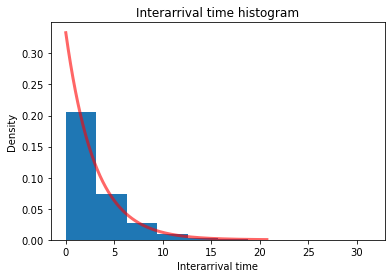

In [14]:
# Generate 1000 exponential random variates
iat_sample = rg.exponential(mean_interarrival_time, 10000)

# Create a histogram of the random samples with exponential pdf overlaid


plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(iat_sample, density=True);

x_expon = np.linspace(rv_expon.ppf(0.0001),
                rv_expon.ppf(0.999), 500)

plt.plot(x_expon, rv_expon.pdf(x_expon),
       'r-', lw=3, alpha=0.6, label='Exponential pdf');



In [15]:
def patient_arrivals_random_1(env, mean_interarrival_time=5.0, rg=default_rng(0)):
    """Generate patients according to a Poisson arrival process

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        mean_interarrival_time : float (default=5.0)
            mean number of time units between arrivals
    """

    # Create a counter to keep track of number of patients generated
    patients_created = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time 
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of patients
        patients_created += 1
        
        print(f"Patient {patients_created} created at time {env.now}")



In [18]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts and adds it to env
runtime = 25
interarrival_time = 3.0
env2.process(patient_arrivals_random_1(env2, interarrival_time))

# Run the simulation
env2.run(until=runtime)

Patient 1 created at time 5.010960706388282
Patient 2 created at time 6.576757134862282
Patient 3 created at time 11.841854301655367
Patient 4 created at time 14.886585611698054
Patient 5 created at time 14.922733708929394
Patient 6 created at time 19.03370491108523
Patient 7 created at time 23.27472432120521
Patient 8 created at time 24.79016294990382
Patient 9 created at time 24.830183133017577


## Adding a simple delay process

Let's extend the model a bit by adding a simple delay process. In other words, let's pretend that after a patient arrives, the patient spends a random amount of time to go through all the stages of the vaccination process. In other words we are grossly oversimplifying the real system by ignorning all the details of the vaccination process. Let's model this total time in the vaccination clinic with another exponential distribution having a mean of 20 minutes.

To do this, we'll do two main things:

* Create a new process function for the delay process
* Modify the arrival process to create a delay event for each patient arrival

Let's also add a `verbose` parameter.

* if `verbose >= 1`, we'll print the process status messages
* if `verbose == 0`, we won't print the status messages

In [21]:
def patient_arrivals_random(env, mean_interarrival_time=5.0, mean_delay_time=15.0, rg=default_rng(0), verbose=1):
    """Generate patients according to a Poisson arrival process

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        mean_interarrival_time : float (default=5.0)
            mean number of time units between arrivals
    """

    # Create a counter to keep track of number of patients generated
    patients_created = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of patients
        patients_created += 1
        if verbose:
            print(f"Patient{patients_created} created at time {env.now}")
        
        # Create a new patient delay process.
        delay_time = rg.exponential(mean_delay_time)
        patient_visit = delay_process(env, 'Patient{}'.format(patients_created), delay_time)
        # Register the process with the simulation environment
        env.process(patient_visit)
        

        

def delay_process(env, name, delay_time, verbose=1):
    """Process function modeling how a patient flows through system.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        name : str
            process instance id
        mean_delay_time : float
            mean amount of time patient is in system to be vaccinated
    """

    # Note how we are simply modeling the ebture clinic visit as a delay. There
    # is NO contention for any resources.
    if verbose:
        print(f"{name} entering vaccination clinic at {env.now:.4f}")
    
    yield env.timeout(delay_time)
    
    if verbose:
        print(f"{name} exiting vaccination clinic at {env.now:.4f}")
        
# Initialize a simulation environment
env3 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts and adds it to env

mean_interarrival_time = 3.0
mean_delay_time = 20.0
env3.process(patient_arrivals_random(env3, mean_interarrival_time, mean_delay_time))

# Run the simulation
runtime = 25
env3.run(until=runtime)

Patient1 created at time 2.039795711906729
Patient1 entering vaccination clinic at 2.0398
Patient2 created at time 2.099215699673895
Patient2 entering vaccination clinic at 2.0992
Patient2 exiting vaccination clinic at 2.1446
Patient3 created at time 3.7502443175910396
Patient3 entering vaccination clinic at 3.7502
Patient4 created at time 5.770993175592736
Patient4 entering vaccination clinic at 5.7710
Patient5 created at time 14.221351112819914
Patient5 entering vaccination clinic at 14.2214
Patient4 exiting vaccination clinic at 20.8770
Patient1 exiting vaccination clinic at 22.4317
Patient6 created at time 24.080635886501145
Patient6 entering vaccination clinic at 24.0806
Patient6 exiting vaccination clinic at 24.1064


## An object oriented (OO) version of our first model
While SimPy can be used with both non-OO and OO style programs, most of the examples in the documentation use an OO approach. Also, I've found the OO approach to lend itself better to creating modular code and more flexible from a modeling perspective. So, let's repeat the above simple delay model with OO code.

perfect_squares()

In [ ]:
class PatientArrivalGenerator(object):
    """ Generates patients.

        Set the "out" member variable to resource at which patient generated.

        Parameters
        ----------
        env : simpy.Environment
            the simulation environment
        mean_interarrival_time : float
            Poisson arrival rate (expected number of arrivals per unit time)
        mean_delay_time : float
            Starts generation after an initial delay. (default 0.0)
        rg : 
            random number generator
        verbose: int
            If > 0, status message printed after
            each patient created. (default 1)

    """

    def __init__(self, mean_interarrival_time=5.0, mean_delay_time=15.0, rg=default_rng(0), verbose=1):

        self.env = env
        self.mean_interarrival_time = mean_interarrival_time
        self.mean_delay_time = mean_delay_time
        self.rg = rg
        self.verbose = verbose

        self.action = env.process(self.run())  # starts the run() method as a SimPy process

    def run(self):
        """The arrival generator.
        """

        while True:
            # Delay until time for next arrival
            # Compute next interarrival time

            iat = self.rg.exponential(self.mean_interarrival_time)
        
            # This process will now yield to a 'timeout' event. This process will resume after iat time units.
            yield self.env.timeout(iat)
            
            # Update counter of patients
            self.patients_created += 1
            if self.verbose:
                print(f"Patient{self.patients_created} created at time {self.env.now}")

            # Create a new patient delay process.
            delay_time = rg.exponential(mean_delay_time)
            patient_visit = delay_process(env, 'Patient{}'.format(patients_created), delay_time)
            # Register the process with the simulation environment
            env.process(patient_visit)
            
            